In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

c:\Users\USER\OneDrive - UNIVERSITAS INDONESIA\COOLYEAH\smt 8\tugas akhir\topic-modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_01 = pd.read_csv('data/stemmed_merged_kubu_01.csv')
df_02 = pd.read_csv('data/stemmed_merged_kubu_02.csv')
df_03 = pd.read_csv('data/stemmed_merged_kubu_03.csv')

In [4]:
# Indonesian stopwords plus election-specific terms
indo_stopwords = [
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    # Election-specific terms that appear everywhere
    "anies", "baswedan", "muhaimin", "iskandar", "cak", "imin", "gus", "presiden", 
    "wakil", "calon", "ri", "mas", "pilih", "santri"
]

In [ ]:
# Configure a more targeted vectorizer for Indonesian political content
vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=3,            # Lower threshold to capture more specific topics
    max_df=0.6           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=10,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.1,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=5,  # Smaller clusters to capture specific campaign themes
    min_samples=3,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=10,             # Reduced from 15 to get more focused topics
    min_topic_size=5,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
)

# Fit the model
topics, probs = topic_model.fit_transform(df_01['full_text'].tolist())

2025-05-20 20:21:28,145 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 934/934 [02:47<00:00,  5.59it/s]
2025-05-20 20:24:19,422 - BERTopic - Embedding - Completed ✓
2025-05-20 20:24:19,422 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 20:25:06,430 - BERTopic - Dimensionality - Completed ✓
2025-05-20 20:25:06,432 - BERTopic - Cluster - Start clustering the reduced embeddings


In [ ]:
# Generate more intuitive topic labels
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Miscellaneous"
        continue
        
    # Get top words
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to campaign themes based on keywords
    if any(term in words for term in ["palestina", "doa", "gelar", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Palestina"
    elif any(term in words for term in ["aceh", "warga", "sambut", "bandara", "kedatagan"]):
        topic_labels[topic_id] = "Kunjungan ke Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "barat", "safari"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "rakyat"]):
        topic_labels[topic_id] = "Visi Keadilan & Kemakmuran"
    elif any(term in words for term in ["menang", "indonesia", "senang", "bismillah"]):
        topic_labels[topic_id] = "Dukungan Kemenangan"
    elif any(term in words for term in ["pesantren", "santri", "tenanan", "kiai"]):
        topic_labels[topic_id] = "Dukungan Pesantren & Santri"
    elif any(term in words for term in ["partai", "bangkit", "bangsa"]):
        topic_labels[topic_id] = "Dukungan Partai Politik"
    else:
        # Use top 3 words as label for other topics
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)


Topic Information:
   Topic  Count                                               Name  \
0     -1  14140         -1_calon presiden_pilih presiden_orang_sih   
1      0   8138                 0_anjing_01 menang_buzzer_pilih 01   
2      1   5046  1_rasyid_video_anies rasyid_anies rasyid baswedan   
3      2   1278                       2_indonesia_pop_better_juang   
4      3    338                             3_akun_bayar_duit_uang   
5      4    251               4_kayak_01 kayak_elektabilitas_angin   
6      5    241                    5_muda_kampus_sekolah_anak muda   
7      6    174                        6_foto_warna_kamera_kreatif   
8      7    115                          7_malaikat_cat_kaki_abdel   
9      8     62                         8_pangan_tani_blak_mandiri   

                                      Representation  \
0  [calon presiden, pilih presiden, orang, sih, p...   
1  [anjing, 01 menang, buzzer, pilih 01, maaf, su...   
2  [rasyid, video, anies rasyid, anies ra

In [ ]:
# Get the improved topic information
topic_info = topic_model.get_topic_info()
print("\nImproved Topic Information:")
print(topic_info.head(10))

# Print topics with their new labels
print("\nCampaign Themes for Anies-Muhaimin:")
for index, row in topic_info.iterrows():
    if row["Topic"] != -1:  # Skip outlier topic
        topic_id = row["Topic"]
        words = [word[0] for word in topic_model.get_topic(topic_id)[:8]]
        print(f"Theme: {row['Name']}")
        print(f"Keywords: {', '.join(words)}")
        print(f"Document count: {row['Count']}")
        print("-" * 50)

# Create a topic distribution visualization
plt.figure(figsize=(12, 6))
topic_counts = topic_info[topic_info["Topic"] != -1]["Count"]
topic_names = [label for topic, label in topic_labels.items() if topic != -1]
plt.bar(topic_names, topic_counts)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Campaign Themes in Anies-Muhaimin Tweets")
plt.tight_layout()
plt.show()


Top Words per Topic:
Topic 0: 01, anies, imin, cak, dukung, pilih, calon, presiden, baswedan, pasang
Topic 1: bandara, sambut, pesawat, medan, baswedan, warga, darat, anies, antusias, rawan
Topic 2: viral, mandatory, vaksin, vaccine, virus, resah, koar, massa, bobon, desantis
Topic 3: bibir, lip, warna, pakai, merah, tint, shade, muda, implora, cantik
Topic 4: migrasi, kerja, tenaga, asing, buruh, baswedan, hilir, nntinya, omon, hak
Topic 5: disabilitas, anak, momen, aceh, isyarat, anies, masyaallah, baswedan, teman, bahasa
Topic 6: template, ulang, jelek, adopsi, lontar, cermat, wir, gocek, 01, sarkas
Topic 7: otot, basi, sampai, materi, latih, oenderitaan, wkwkkwwk, nampung, kenceng, subtansi
Topic 8: mikro, tengah, usaha, makro, pasar, manchester, united, cipta, cak, imin
Topic 9: judi, online, berantas, angin, haram, digimanain, alasn, pinjamn, berktp, kepret
Topic 10: undang, transaksi, elektronik, informasi, kena, ngeberesin, ujicoba, sensor, iqnya, babas
Topic 11: jenggot, baka

In [7]:
from wordcloud import WordCloud
import seaborn as sns

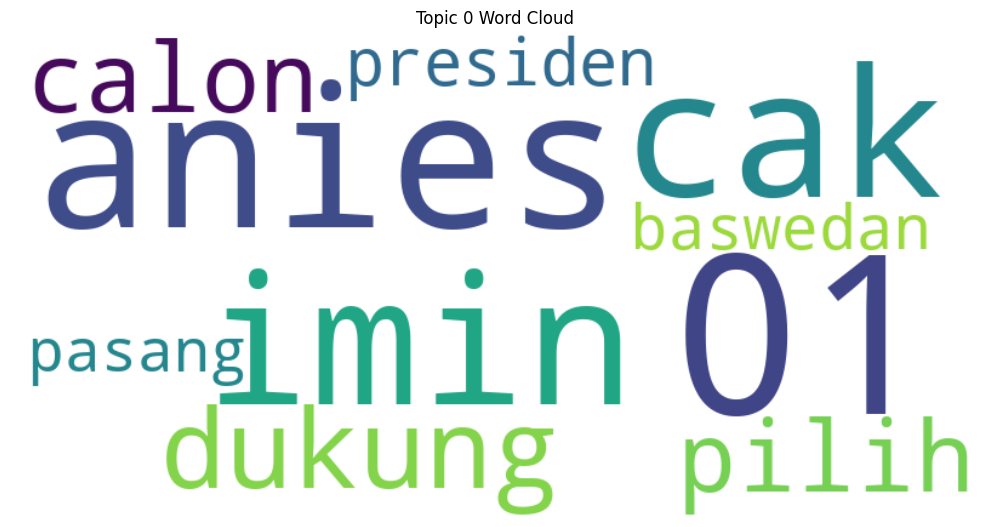

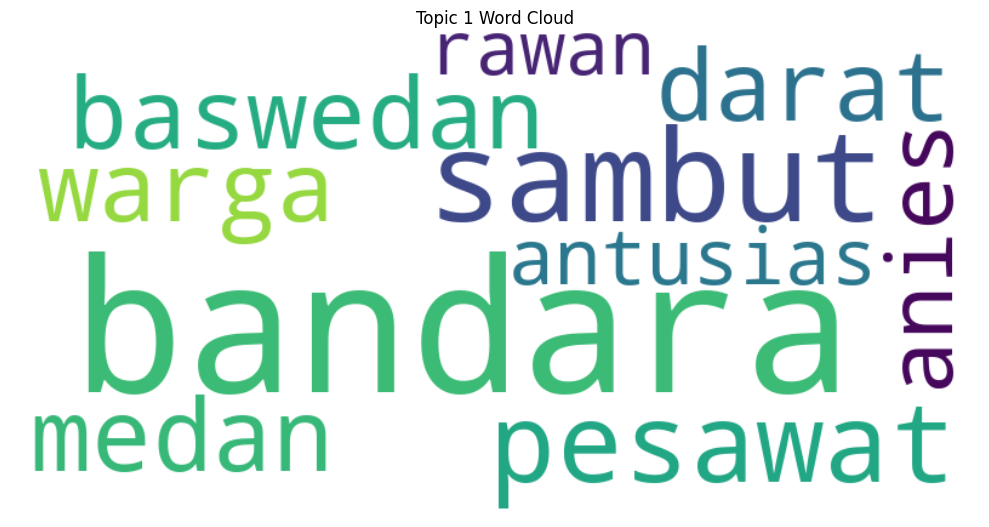

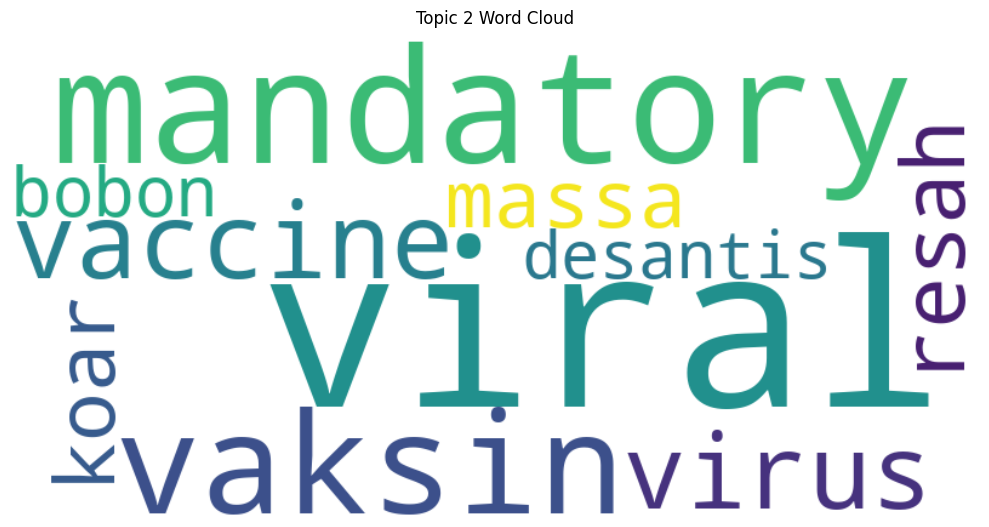

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Get representative documents for key campaign themes
print("\nRepresentative tweets for key campaign themes:")
key_topics = [t for t in topic_distribution.index if t != -1][:5]

for topic_id in key_topics:
    theme_name = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
    print(f"\n--- Theme: {theme_name} ---")
    rep_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(rep_docs[:3]):
        print(f"{i+1}. {doc[:200]}...")


Representative tweets for top topics:

--- Topic 0 ---
1. narasi kayak dukung pasang calon 01 turun elektabilitas pasang calon dukung kecuali asli dukung pasang calon...
2. anies baswedan sosok pimpin inspirasi orang prabowo subianto keren anies baswedan pilih pasang calon 01 anies gus presiden ri...
3. anies coblos pasang calon 01...

--- Topic 1 ---
1. pagi anies baswedan bandara tasikmalaya sambut hangat rawan warga...
2. bandara kualanamu lapor mas presiden anies sambut warga medan horas...
3. anies baswedan darat bandara morowali sulawesi sambut antusias warga...

--- Topic 2 ---
1. ayo viral hasil 01 versi dukung amin...
2. viral massa pakai baju prabowo gibran pilih anies baswedan...
3. cak imin langsung viral wkwk...

--- Topic 3 ---
1. pakai buttered lip balm pagi malam pakai peppermint somehow kayak bikin bibir plumpy sksksk pakai emina lip mask deh habis malam pakai lip serum emina shade 01 dawn minggu kali scrub bibir pakai sikat...
2. 01 mariposa warna cangtip foto merah 